## Import

In [ ]:
from qiskit_finance.data_providers import RandomDataProvider
import datetime
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms import QAOA
from qiskit_aer.primitives import Sampler
from qiskit.result import QuasiDistribution
from qiskit_algorithms.utils import algorithm_globals
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_algorithms import SamplingVQE
from qiskit.circuit.library import TwoLocal
from qiskit_aer.primitives import Sampler

import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


## Generazione dei dati

In [68]:

assets = 4
seed = 2024


start_date = datetime.datetime(2020, 1, 1)
end_date = datetime.datetime(2024, 1, 1)

stocks = [("TICKER_%s" % i) for i in range(assets)]
data_provider = RandomDataProvider(
    tickers=stocks,
    start=start_date,
    end=end_date,
    seed=seed,
)

data_provider.run()
# print(data_provider._data)

## Stampa dei dati

In [69]:
stock_data = data_provider._data

# devo escludere il giorno di inizio o di fine perché non viene considerato
dates = pd.date_range(start=start_date, end=end_date, inclusive="left")

# print(dates)
print(f"\nDati Generati per il periodo dal {start_date.date()} al {end_date.date()}:")
print("-" * 80)
print(f"{'Data':<12}", end="")
for i in range(len(stock_data)):
    print(f"TICKER_{i:<5}", end="")
print()

for i, date in enumerate(dates):
    # print(i)
    # print(f"{date.date():<12}", end="")
    print(f"{date.strftime('%Y-%m-%d'):<12}", end="")
    
    # print(stock_data[i])
    for j in range(len(stock_data)):
        print(f"{stock_data[j][i]:<12.4f}", end="")
    
    print()
print("-" * 80)


Dati Generati per il periodo dal 2020-01-01 al 2024-01-01:
--------------------------------------------------------------------------------
Data        TICKER_0    TICKER_1    TICKER_2    TICKER_3    
2020-01-01  99.0289     3.5260      6.8573      54.4612     
2020-01-02  100.6708    2.9833      5.4862      52.5775     
2020-01-03  101.8175    2.9753      5.2525      51.5572     
2020-01-04  100.8443    2.2909      5.8572      52.2459     
2020-01-05  99.4515     1.7600      6.4830      52.7167     
2020-01-06  99.5187     1.4305      6.0582      52.4356     
2020-01-07  100.3801    2.6973      6.4843      52.2698     
2020-01-08  100.8893    0.4074      5.8157      51.3576     
2020-01-09  102.6995    2.0457      5.3425      51.7999     
2020-01-10  103.4504    2.9036      5.5465      51.9648     
2020-01-11  104.0901    0.9871      4.6445      52.2332     
2020-01-12  103.3588    1.4963      4.6533      52.4298     
2020-01-13  102.2511    0.9994      3.8690      52.9711     
2020-

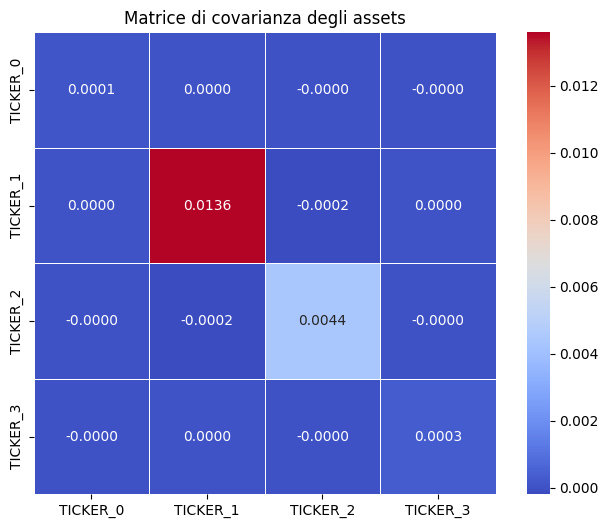

In [70]:
mu = data_provider.get_period_return_mean_vector()
sigma = data_provider.get_period_return_covariance_matrix()

sigma_df = pd.DataFrame(sigma, index=stocks, columns=stocks)

plt.figure(figsize=(8, 6))
sns.heatmap(
    sigma_df, 
    annot=True,
    fmt=".4f",
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5,
    square=True
)
plt.title("Matrice di covarianza degli assets")
plt.show()

In [71]:
risk_factor = 0.5
# 50% of the assets
budget = assets // 2

# penalty = assets
po = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=risk_factor, budget=budget
)
qp = po.to_quadratic_program()
# print(qp)

## Solvers

In [72]:
# classical
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)


# common vars for VQE and QAOA
algorithm_globals.random_seed = seed
cobyla = COBYLA()
iter = 1000
cobyla.set_options(maxiter=iter)

# VQE

ry = TwoLocal(assets, "ry", "cz", reps=1, entanglement="full", insert_barriers=True)
svqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)
svqe = MinimumEigenOptimizer(svqe_mes)

# QAOA
algorithm_globals.random_seed = seed

qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=1)
qaoa = MinimumEigenOptimizer(qaoa_mes)

## Grafici

### Distribuzione delle selezioni su n iterazioni
Si vuole ottenere un bar plot dove si rappresentano le distribuzioni delle selezioni degli asset effettuate da ciascun algoritmo a rischio costante (0.5) su n ripetizioni. In questo caso, la selezione di ogni asset è rappresentata da un valore binario (1 = selezionato, 0 = non selezionato) e si analizzano le frequenze di selezione degli asset per ciascun algoritmo.

Verranno creati i seguenti bar plot:

- Un bar plot per ciascun algoritmo (QAOA, SVQE, Exact Eigensolver) che mostra il numero di selezioni per ogni asset.
- Un bar plot complessivo che confronta la distribuzione delle selezioni tra tutti e tre gli algoritmi.

L'analisi aiuterà a comprendere la distribuzione delle scelte degli asset in funzione del rischio, e a visualizzare eventuali differenze nel comportamento degli algoritmi.

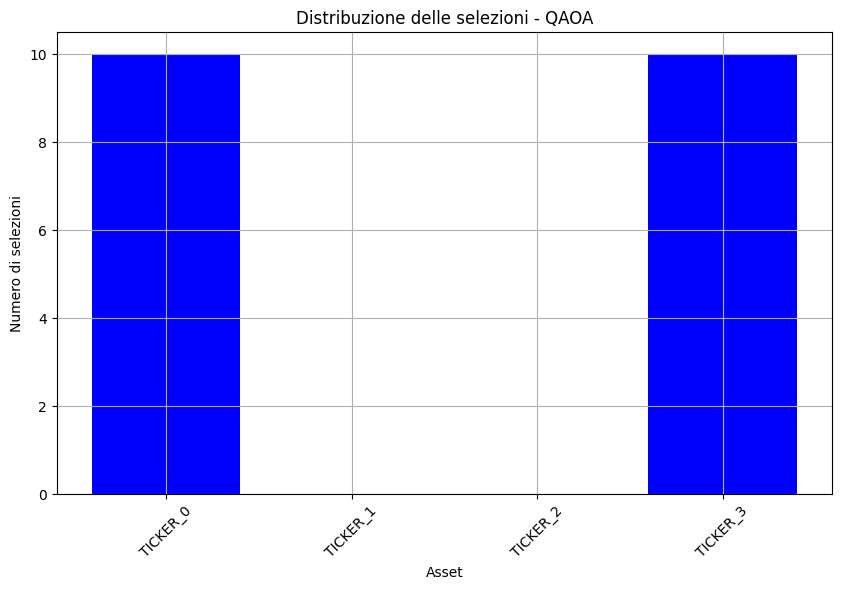

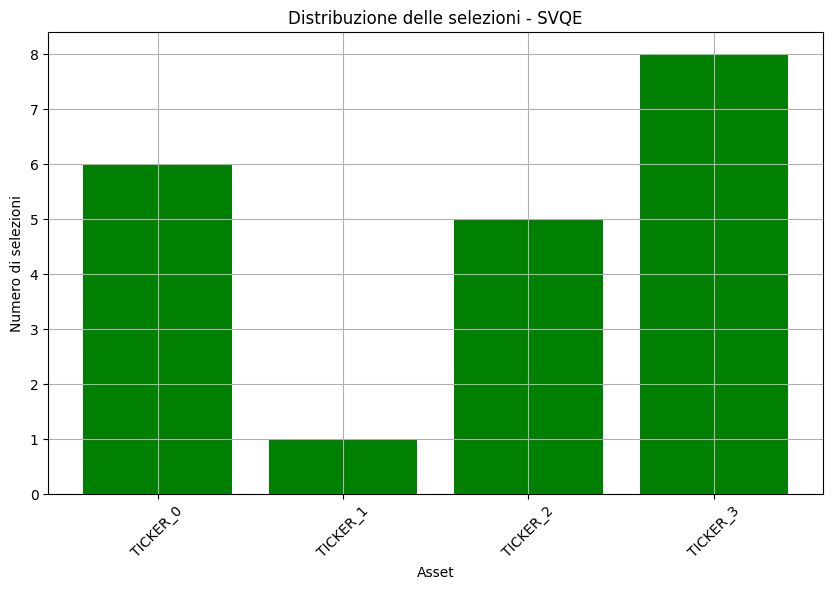

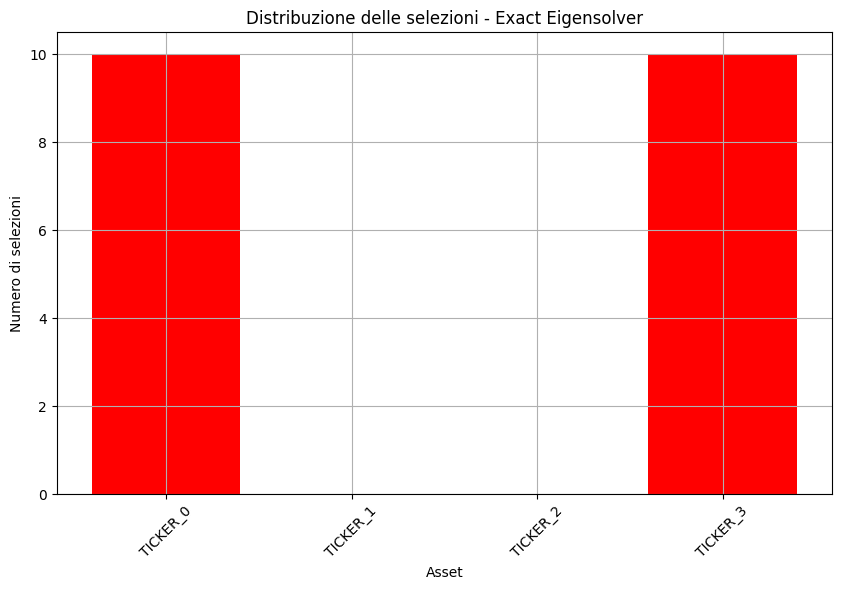

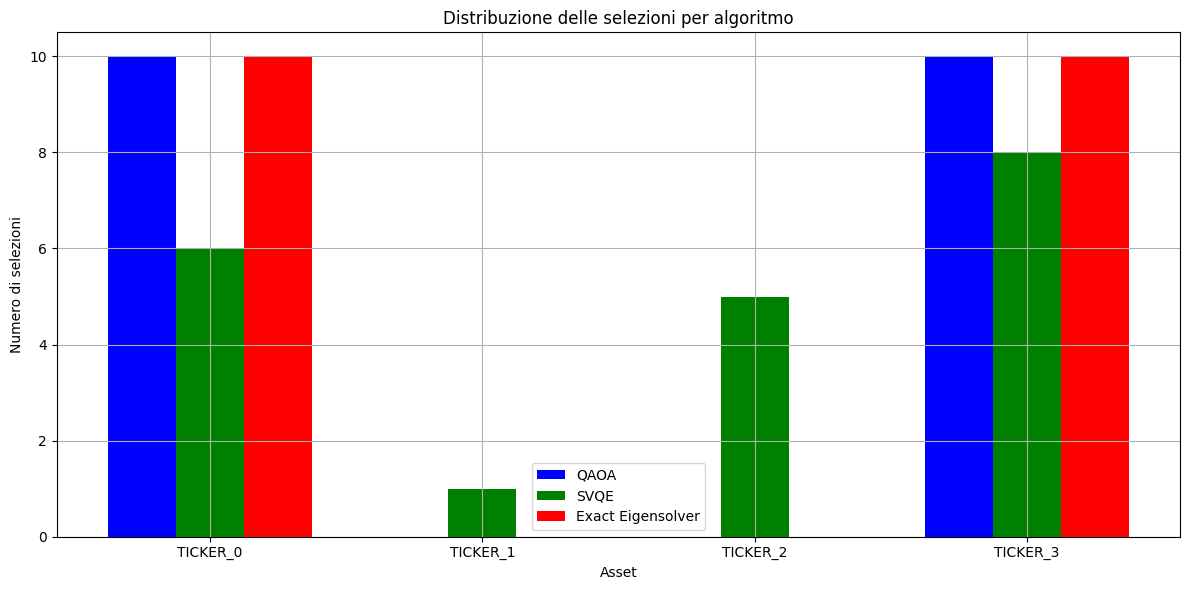

In [73]:
import matplotlib.pyplot as plt
import numpy as np

n_repeats = 10
risk_factor = 0.5

selections_qaoa = np.zeros((n_repeats, len(stocks)))
selections_svqe = np.zeros((n_repeats, len(stocks)))
selections_exact_eigensolver = np.zeros((n_repeats, len(stocks)))

po = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=risk_factor, budget=budget)
qp = po.to_quadratic_program()

for i in range(n_repeats):
    result_qaoa = qaoa.solve(qp)
    selections_qaoa[i] = result_qaoa.x

    result_svqe = svqe.solve(qp)
    selections_svqe[i] = result_svqe.x

    result_exact = exact_eigensolver.solve(qp)
    selections_exact_eigensolver[i] = result_exact.x

selection_counts_qaoa = np.sum(selections_qaoa, axis=0)
selection_counts_svqe = np.sum(selections_svqe, axis=0)
selection_counts_exact_eigensolver = np.sum(selections_exact_eigensolver, axis=0)

plt.figure(figsize=(10, 6))
plt.bar(stocks, selection_counts_qaoa, color='blue')
plt.title("Distribuzione delle selezioni - QAOA")
plt.xlabel("Asset")
plt.ylabel("Numero di selezioni")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(stocks, selection_counts_svqe, color='green')
plt.title("Distribuzione delle selezioni - SVQE")
plt.xlabel("Asset")
plt.ylabel("Numero di selezioni")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(stocks, selection_counts_exact_eigensolver, color='red')
plt.title("Distribuzione delle selezioni - Exact Eigensolver")
plt.xlabel("Asset")
plt.ylabel("Numero di selezioni")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

width = 0.25
x = np.arange(len(stocks))

plt.figure(figsize=(12, 6))
plt.bar(x - width, selection_counts_qaoa, width, color='blue', label='QAOA')
plt.bar(x, selection_counts_svqe, width, color='green', label='SVQE')
plt.bar(x + width, selection_counts_exact_eigensolver, width, color='red', label='Exact Eigensolver')

plt.title('Distribuzione delle selezioni per algoritmo')
plt.xlabel('Asset')
plt.ylabel('Numero di selezioni')
plt.xticks(x, stocks)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Grafici delle combinazioni

Questa sezione mostra i grafici delle combinazioni di asset selezionati per ogni algoritmo e un grafico combinato che visualizza tutte le combinazioni insieme.

### Grafici a barre
Vengono mostrati i grafici a barre per ogni algoritmo utilizzato e un grafico combinato che visualizza tutte le combinazioni insieme.

{'qaoa': {(0, 0, 0, 0): 0, (0, 0, 0, 1): 0, (0, 0, 1, 0): 0, (0, 0, 1, 1): 0, (0, 1, 0, 0): 0, (0, 1, 0, 1): 0, (0, 1, 1, 0): 0, (0, 1, 1, 1): 0, (1, 0, 0, 0): 0, (1, 0, 0, 1): 10, (1, 0, 1, 0): 0, (1, 0, 1, 1): 0, (1, 1, 0, 0): 0, (1, 1, 0, 1): 0, (1, 1, 1, 0): 0, (1, 1, 1, 1): 0}, 'svqe': {(0, 0, 0, 0): 0, (0, 0, 0, 1): 0, (0, 0, 1, 0): 0, (0, 0, 1, 1): 3, (0, 1, 0, 0): 0, (0, 1, 0, 1): 1, (0, 1, 1, 0): 0, (0, 1, 1, 1): 0, (1, 0, 0, 0): 0, (1, 0, 0, 1): 6, (1, 0, 1, 0): 0, (1, 0, 1, 1): 0, (1, 1, 0, 0): 0, (1, 1, 0, 1): 0, (1, 1, 1, 0): 0, (1, 1, 1, 1): 0}, 'exact': {(0, 0, 0, 0): 0, (0, 0, 0, 1): 0, (0, 0, 1, 0): 0, (0, 0, 1, 1): 0, (0, 1, 0, 0): 0, (0, 1, 0, 1): 0, (0, 1, 1, 0): 0, (0, 1, 1, 1): 0, (1, 0, 0, 0): 0, (1, 0, 0, 1): 10, (1, 0, 1, 0): 0, (1, 0, 1, 1): 0, (1, 1, 0, 0): 0, (1, 1, 0, 1): 0, (1, 1, 1, 0): 0, (1, 1, 1, 1): 0}}


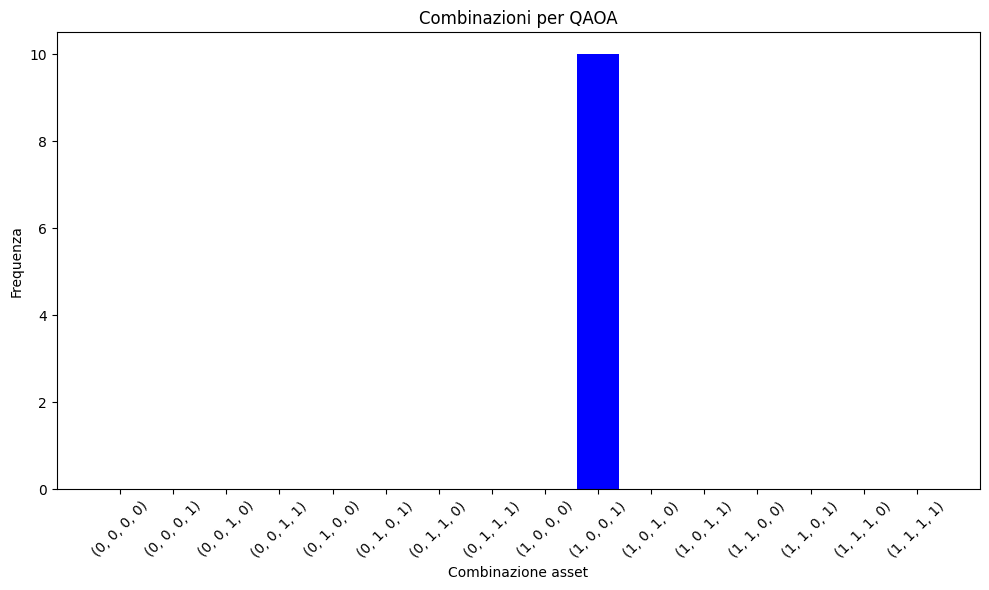

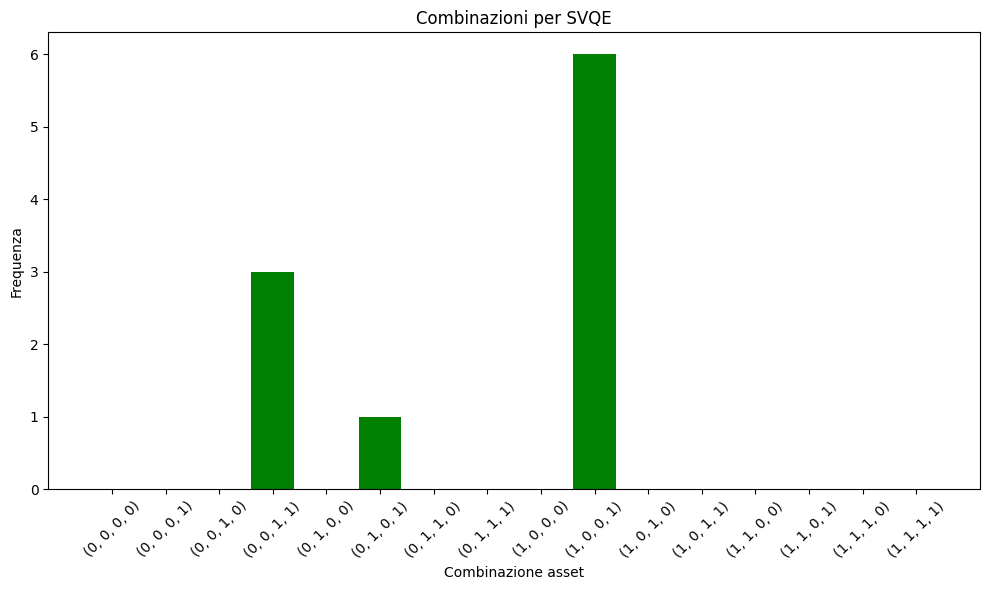

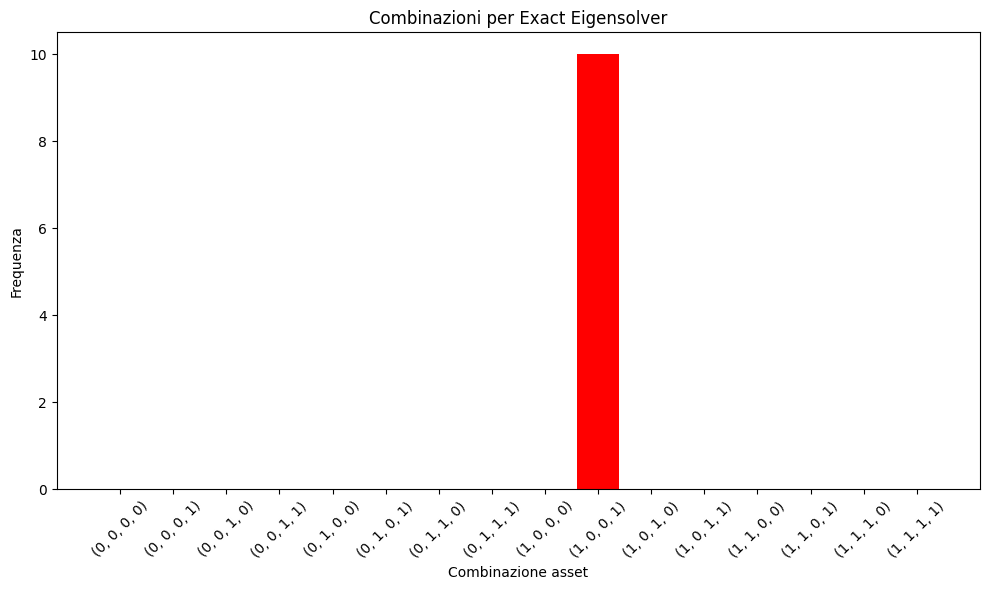

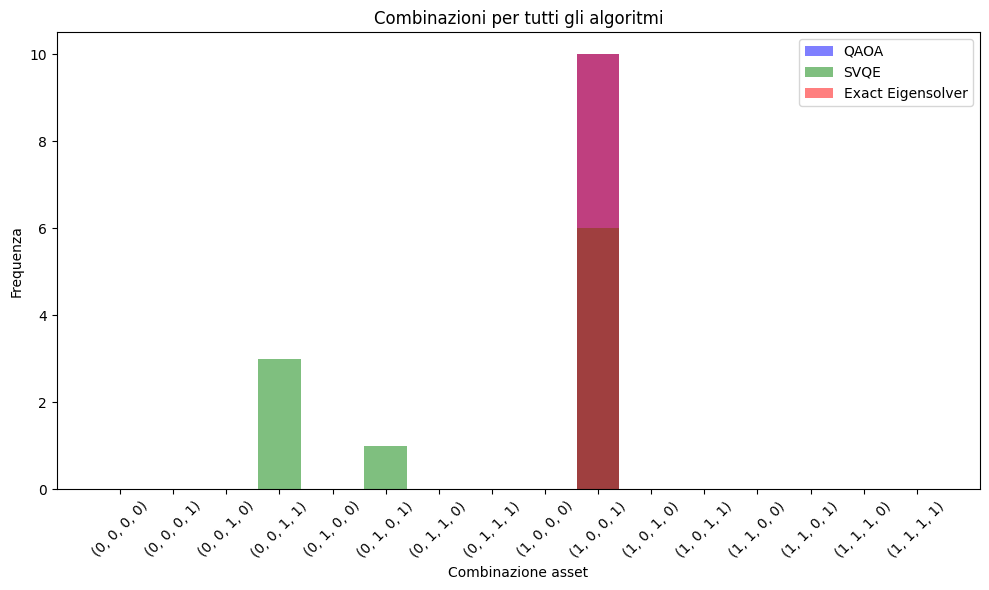

In [77]:
all_combinations = list(itertools.product([0, 1], repeat=assets))
combinations_count = {
    'qaoa': {comb: 0 for comb in all_combinations},
    'svqe': {comb: 0 for comb in all_combinations},
    'exact': {comb: 0 for comb in all_combinations}
}


po = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=risk_factor, budget=budget)
qp = po.to_quadratic_program()

for i in range(n_repeats):
    result_qaoa = qaoa.solve(qp)
    selection_qaoa = tuple(result_qaoa.x)

    result_svqe = svqe.solve(qp)
    selection_svqe = tuple(result_svqe.x)

    result_exact = exact_eigensolver.solve(qp)
    selection_exact = tuple(result_exact.x)
    
    combinations_count['qaoa'][selection_qaoa] += 1
    combinations_count['svqe'][selection_svqe] += 1
    combinations_count['exact'][selection_exact] += 1

# print(combinations_count)


qaua_color = "blue"
svqe_color = "green"
exact_color = "red"

# QAOA
combinations_qaoa = list(combinations_count['qaoa'].keys())
frequencies_qaoa = list(combinations_count['qaoa'].values())

# grafico
plt.figure(figsize=(10, 6))
plt.bar([str(comb) for comb in combinations_qaoa], frequencies_qaoa, color=qaua_color)
plt.title("Combinazioni per QAOA")
plt.xlabel("Combinazione asset")
plt.ylabel("Frequenza")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# SVQE
combinations_svqe = list(combinations_count['svqe'].keys())
frequencies_svqe = list(combinations_count['svqe'].values())

# grafico
plt.figure(figsize=(10, 6))
plt.bar([str(comb) for comb in combinations_svqe], frequencies_svqe, color=svqe_color)
plt.title("Combinazioni per SVQE")
plt.xlabel("Combinazione asset")
plt.ylabel("Frequenza")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Exact Eigensolver
combinations_exact = list(combinations_count['exact'].keys())
frequencies_exact = list(combinations_count['exact'].values())

# grafico
plt.figure(figsize=(10, 6))
plt.bar([str(comb) for comb in combinations_exact], frequencies_exact, color=exact_color)
plt.title("Combinazioni per Exact Eigensolver")
plt.xlabel("Combinazione asset")
plt.ylabel("Frequenza")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

# dati per QAOA
plt.bar([str(comb) for comb in combinations_qaoa], frequencies_qaoa, color=qaua_color, alpha=0.5, label='QAOA')
# dati per SVQE
plt.bar([str(comb) for comb in combinations_svqe], frequencies_svqe, color=svqe_color, alpha=0.5, label='SVQE')
# dati per Exact Eigensolver
plt.bar([str(comb) for comb in combinations_exact], frequencies_exact, color=exact_color, alpha=0.5, label='Exact Eigensolver')

plt.title("Combinazioni per tutti gli algoritmi")
plt.xlabel("Combinazione asset")
plt.ylabel("Frequenza")
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

### Valore vs ritorno atteso

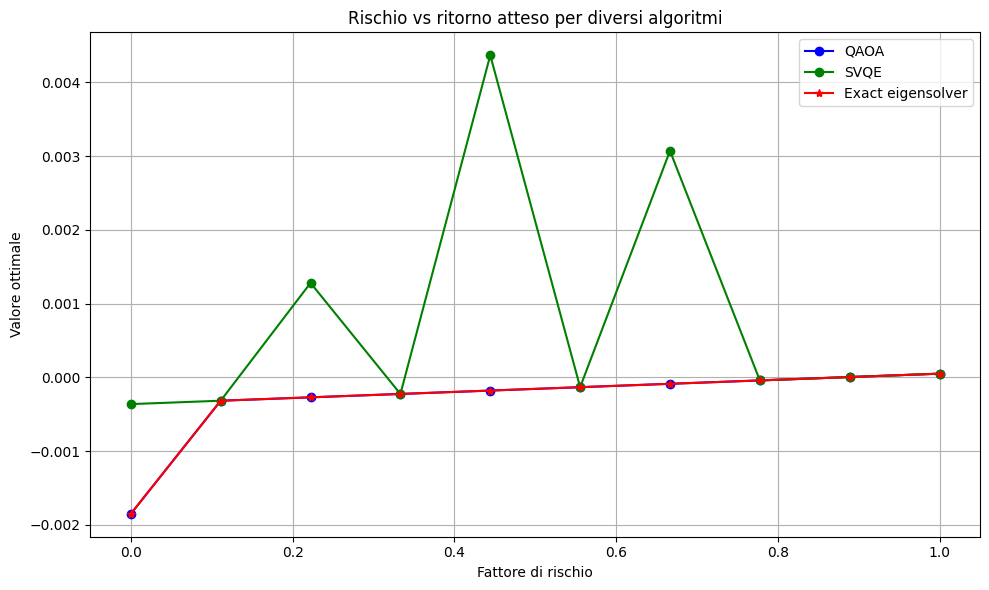

In [75]:
import matplotlib.pyplot as plt
import numpy as np

# Risultati per QAOA
risks = np.linspace(0, 1, 10)
values_per_risk_qaoa = []

for r in risks:
    po = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=r, budget=budget)
    qp = po.to_quadratic_program()
    result = qaoa.solve(qp)
    values_per_risk_qaoa.append(result.fval)

# Risultati per SVQE
values_per_risk_svqe = []

for r in risks:
    po = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=r, budget=budget)
    qp = po.to_quadratic_program()
    result = svqe.solve(qp)
    values_per_risk_svqe.append(result.fval)

# Risultati per Exact Eigensolver
values_exact_eigensolver = []

for r in risks:
    po = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=r, budget=budget)
    qp = po.to_quadratic_program()
    result = exact_eigensolver.solve(qp)
    values_exact_eigensolver.append(result.fval)

# Creazione del grafico
plt.figure(figsize=(10, 6))

# Plot per QAOA
plt.plot(risks, values_per_risk_qaoa, marker='o', linestyle='-', color='b', label='QAOA')

# Plot per SVQE
plt.plot(risks, values_per_risk_svqe, marker='o', linestyle='-', color='g', label='SVQE')

# Plot per Exact Eigensolver
plt.plot(risks, values_exact_eigensolver, marker='*', linestyle='-', color='r', label='Exact eigensolver')

plt.title("Rischio vs ritorno atteso per diversi algoritmi")
plt.xlabel("Fattore di rischio")
plt.ylabel("Valore ottimale")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()